In [1]:
# Imports 
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.environ['pyna_language'] = 'python'
from pyNA.pyna import pyna

In [22]:
def read_controls_file(var, file_name):

    text = open(file_name, "r")
    file = text.read()
    file = file.replace('\n', ' ')

    def find(s, ch):
        return [i for i, ltr in enumerate(s) if ltr == ch]

    if var == 'k':
        control = np.fromstring(file, sep=' ')

    else:
        i_s = find(file, '[')
        i_e = find(file, ']')
        control = np.zeros((np.size(i_s), np.size(np.fromstring(file[i_s[0]+1:i_e[0]], sep=' '))))

        for i in np.arange(np.size(i_s)):
            control[i,:] = np.fromstring(file[i_s[i]+1:i_e[i]], sep=' ')
        
    return control

def read_optimizer_control_inputs(directory_name = ''):

    file_name_k          = directory_name + 'inputs_k.txt'
    file_name_alpha      = directory_name + 'inputs_alpha.txt'
    file_name_TS         = directory_name + 'inputs_TS.txt'
    file_name_theta_flaps= directory_name + 'inputs_theta_flaps.txt'
    file_name_levels_int = directory_name + 'outputs_levels_int.txt'
    
    return_lst = []
    
    # Read objective function
    with open(file_name_levels_int) as f:
        lines_lvl = f.readlines()

    # Extract EPNL
    levels_int = np.zeros((len(lines_lvl), 2))
    for i, line in enumerate(lines_lvl):
        levels_int[i,:] = np.fromstring(line[1:-2], sep=', ')

    return_lst.append(levels_int)
    
    return_lst.append(read_controls_file('k', file_name_k))
    return_lst.append(read_controls_file('alpha', file_name_alpha))
    return_lst.append(read_controls_file('TS', file_name_TS))
    return_lst.append(read_controls_file('theta_flaps', file_name_theta_flaps))
    
    return return_lst

def plot_optimizer_control_inputs(levels_int, k=None, alpha=None, TS=None, theta=None, epnl_constraint=100.):
    
    nvars = 1
    if np.size(k) > 1:
        nvars = nvars + 1    
    if np.size(alpha) > 1:
        nvars = nvars + 1
    if np.size(TS) > 1:
        nvars = nvars + 1
    if np.size(theta) > 1:
        nvars = nvars + 1
    
    # Plot
    fig, ax = plt.subplots(nvars,2,figsize=(16,3.1*nvars))
    plt.style.use('../utils/plot.mplstyle')

    # 1. Objective    
    ax[0,0].plot([0, data['iter'].values[-1]+10], [epnl_constraint, epnl_constraint], 'k', linewidth=1)
    ax[0,0].plot(np.linspace(0, data['iter'].values[-1], np.size(levels_int[:,0])), levels_int[:,0], color='tab:blue')
    ax[0,0].grid(True)
    ax[0,0].set_xlabel('Iteration number [-]')
    ax[0,0].set_ylabel('$EPNL_{lateral}$ \n [EPNdB]')
    
    ax[0,1].plot([0, data['iter'].values[-1]+10], [np.mean(levels_int[-100:,1]), np.mean(levels_int[-100:,1])], 'k', linewidth=1)
    ax[0,1].plot(np.linspace(0, data['iter'].values[-1], np.size(levels_int[:,1])), levels_int[:,1])
    ax[0,1].grid(True)
    ax[0,1].set_xlabel('Iteration number [-]')
    ax[0,1].set_ylabel('$EPNL_{flyover}$ \n [EPNdB]')
        
    # 1. Rotation speed ratio
    if np.size(k) > 1:
        ax[1,0].plot([0, data['iter'].values[-1]+10], [np.mean(k[-100:]), np.mean(k[-100:])], 'k', linewidth=1)
        ax[1,0].plot(np.linspace(0, data['iter'].values[-1], np.size(k)), k, color='tab:blue')
        ax[1,0].set_xlabel('Iteration number [-]')
        ax[1,0].set_ylabel('$k_{rot}$ [-]')
        ax[1,1].axis('off')
        
    # 2. alpha
    if np.size(alpha) > 1:
        for i in np.arange(np.shape(alpha)[1]):
            ax[2,0].plot(np.linspace(0, data['iter'].values[-1], np.size(alpha[:,i])), alpha[:,i])
        ax[2,0].set_ylabel(r'$\alpha_i$ [deg]')
        ax[2,0].set_xlabel('Iteration number [-]')

        N = 200
        ax[2,1].plot(alpha[-1,:], '-', label='Final iteration')
        ax[2,1].plot(np.mean(alpha[-N:,:], axis=0), '--', label='Average over all iterations')
        ax[2,1].set_xlabel('$t_{source}$ [s]')
        ax[2,1].set_ylabel(r'$\alpha$ [deg]')
        ax[2,1].legend(fontsize=14, frameon=False)

    # 3. Thrust setting
    if np.size(TS) > 1:
        for i in np.arange(np.shape(TS)[1]):
            ax[3,0].plot(np.linspace(0, data['iter'].values[-1], np.size(TS[:,i])), TS[:,i])
        ax[3,0].set_ylabel('$TS_i$ [-]')
        ax[3,0].set_xlabel('Iteration number [-]')

        N = 200
        ax[3,1].plot(TS[-1,:], '-', label='Final iteration')
        ax[3,1].plot(np.mean(TS[-N:,:], axis=0), '--', label='Average over all iterations')
        ax[3,1].set_xlabel('$t_{source}$ [s]')
        ax[3,1].set_ylabel('TS [-]')
        ax[3,1].legend(fontsize=14, frameon=False, loc='upper right')

    # 5. Flap deflection angle
    if np.size(theta) > 1:
        for i in np.arange(np.shape(theta)[1]):
            ax[4,0].plot(np.linspace(0, data['iter'].values[-1], np.size(theta[:,i])), theta[:,i])

        ax[4,0].set_ylabel(r'$\theta$ [deg]')
        ax[4,0].set_xlabel('Optimization iteration N')

        ax[4,1].plot(theta[-1,:], '-', label='Final iteration')
        ax[4,1].plot(np.mean(theta[-N:,:], axis=0), '--', label='Average over all iterations')
        ax[4,1].set_xlabel('$t_{source}$ [s]')
        ax[4,1].set_ylabel(r'$\theta$ [deg]')
        ax[4,1].grid(True)
        ax[4,1].legend(fontsize=14, frameon=False, loc='upper right')

    plt.subplots_adjust(wspace=0.3, hspace=0.55)

    return 

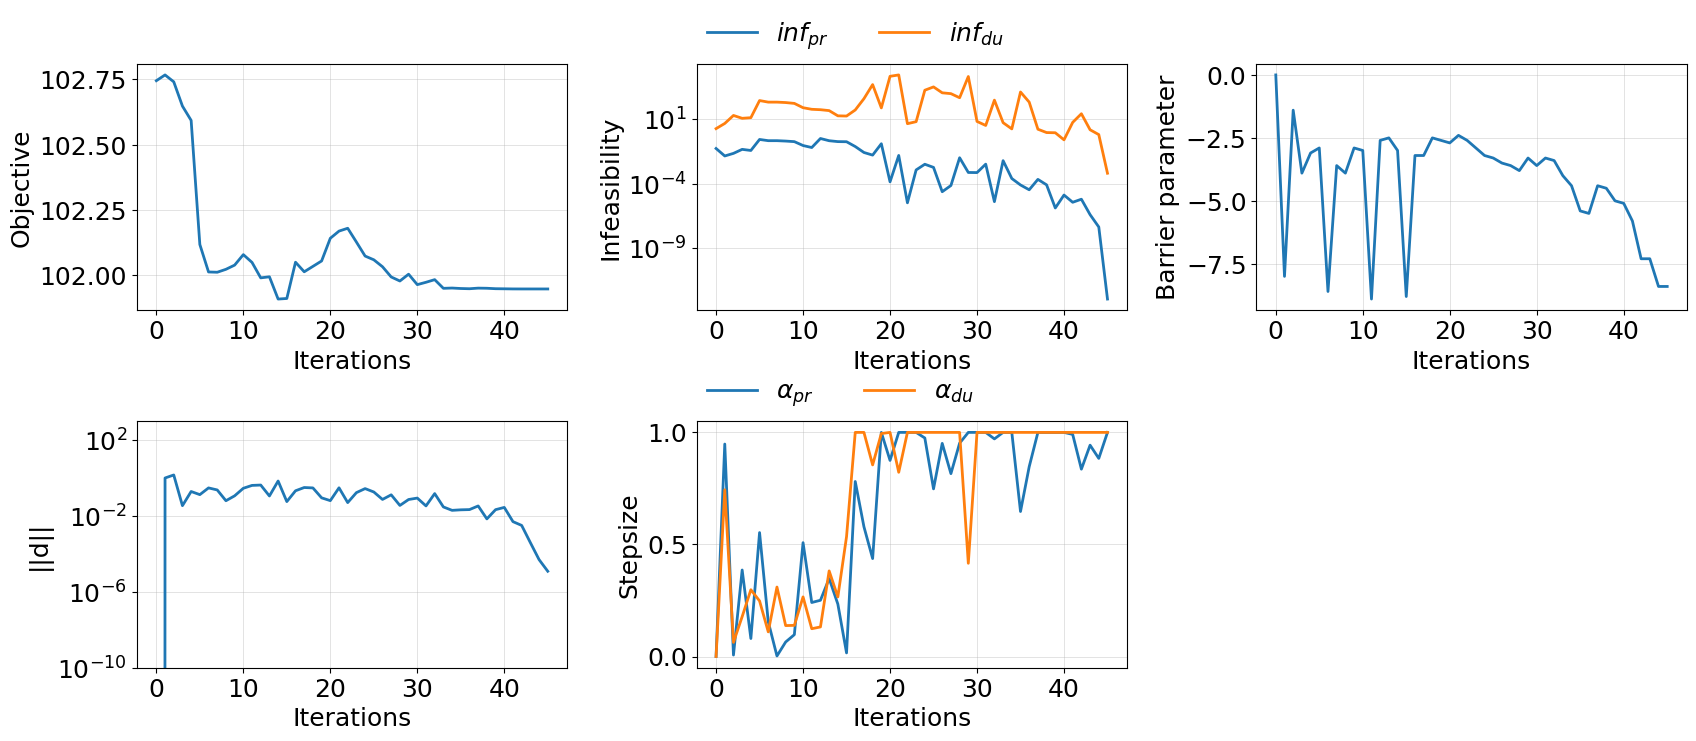

In [251]:
# IPOPT output 
py = pyna()
data = py.plot_optimizer_convergence_data('../cases/a10/output/PTCB/V2/IPOPT_trajectory_convergence.out')


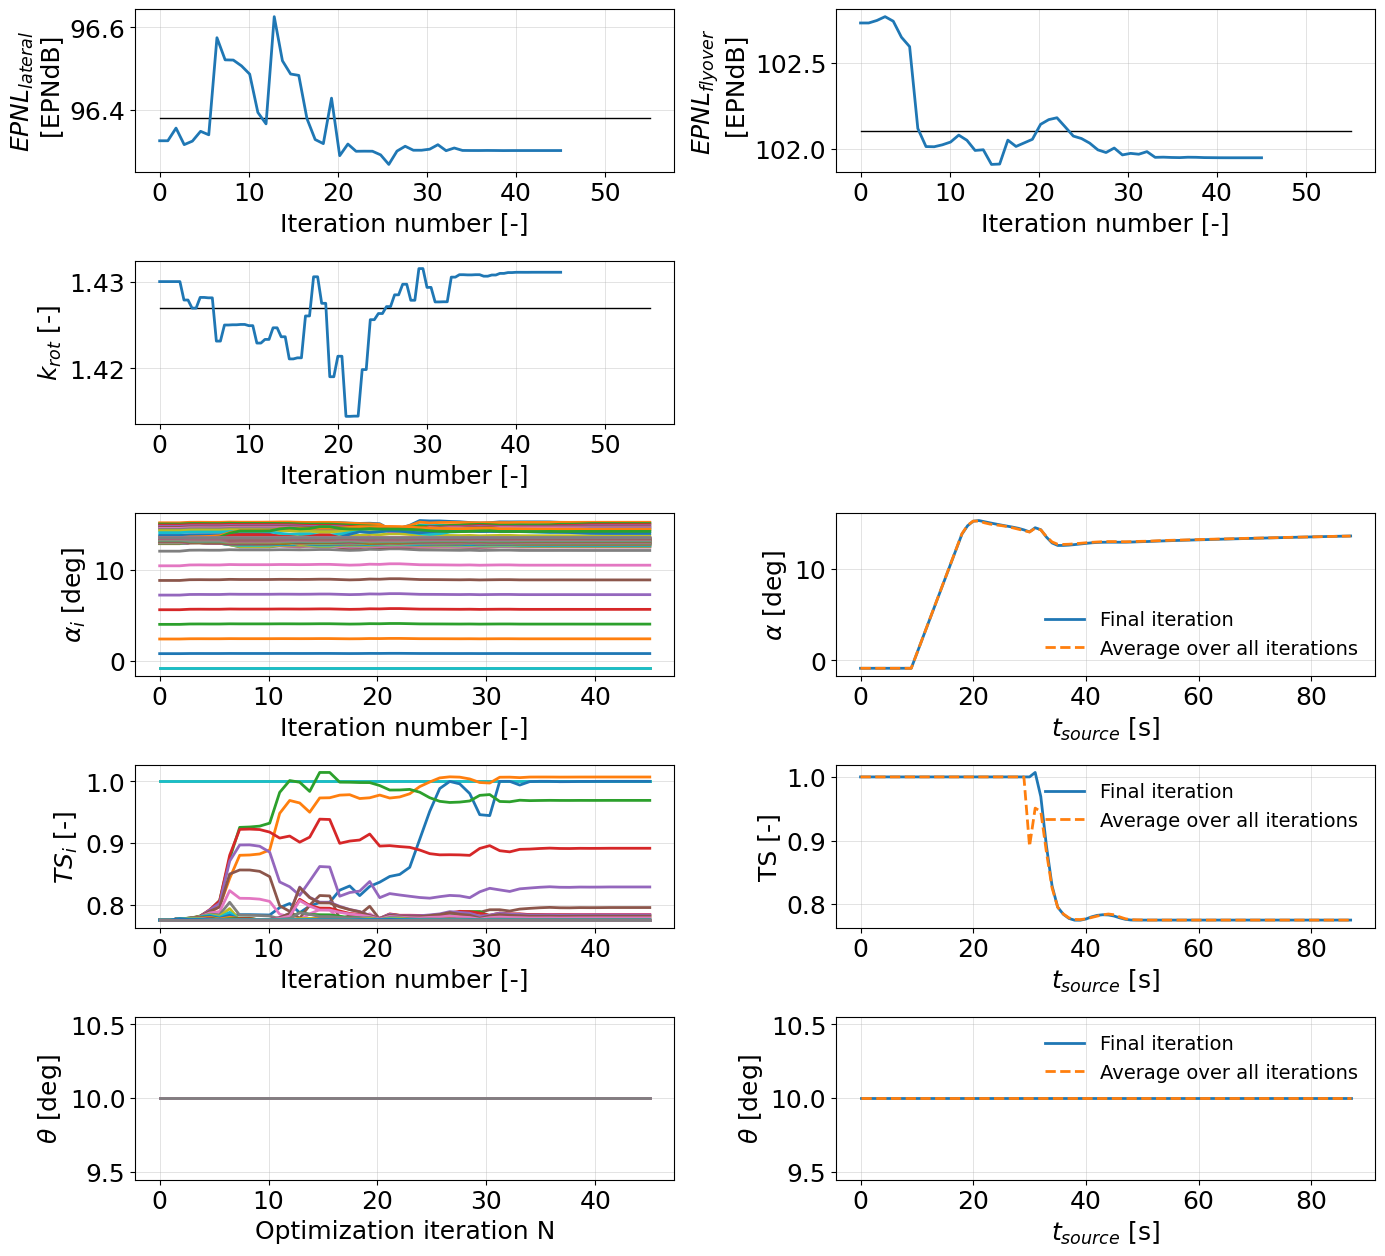

In [252]:
# Load files
levels_int, k, alpha, TS, theta_flaps = read_optimizer_control_inputs('../cases/a10/output/PTCB/V2/')

plot_optimizer_control_inputs(levels_int, k, alpha, TS, theta_flaps, epnl_constraint=96.27878407+0.1)
